## Practice

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import requests_cache
import yfinance as yf
import pandas_datareader as pdr
from typing import Dict, Optional, Tuple, Union

In [2]:
%config InlineBackend.figure_format = 'retina'
%precision 4
pd.options.display.float_format = '{:.4f}'.format
session = requests_cache.CachedSession()

In [3]:
def analyze_market_returns(
    start_year: str = '1900',
    show_plots: bool = True,
    figsize: Tuple[int, int] = (10, 6),
    autocorr_lags: int = 10,
    leverage_alpha: float = 0.1
) -> Dict:
    """
    Performs comprehensive market return analysis including comparisons of log/simple returns,
    autocorrelations, and leverage effects at different frequencies.
    
    Parameters:
    -----------
    start_year : str, default '1900'
        Starting year for the analysis
    show_plots : bool, default True
        If True, displays all visualization plots
    figsize : tuple, default (10, 6)
        Figure size for plots (width, height)
    autocorr_lags : int, default 10
        Number of lags for autocorrelation analysis
    leverage_alpha : float, default 0.1
        Alpha value for scatter plot transparency
        
    Returns:
    --------
    dict
        Contains all market data and analysis results
    """
    # Helper functions
    def totret(x: pd.Series) -> float:
        """Calculate total return."""
        return (1 + x).prod() - 1
    
    def plot_compare_returns(x: pd.DataFrame, freq: str, labs: Dict[str, str]) -> None:
        """Plot comparison of log and simple returns."""
        plt.figure(figsize=figsize)
        x.plot(x='R', y='logR', kind='scatter')
        plt.title(f'Comparison of {freq} Log and Simple Returns')
        plt.xlabel(labs['R'])
        plt.ylabel(labs['logR'])
        plt.show()
    
    def plot_autocorr(x: pd.DataFrame, freq: str, n: int, labs: Dict[str, str]) -> None:
        """Plot autocorrelation analysis."""
        x_lags = pd.concat(objs=[x['R'].shift(t) for t in range(n + 1)], axis=1)
        corrs = x_lags.corr().iloc[0]
        serrs = np.sqrt((1 - corrs**2) / (x_lags.count() - 2))
        
        plt.figure(figsize=figsize)
        plt.bar(height=corrs, x=range(n + 1), yerr=2*serrs)
        plt.title(
            f'Autocorrelation of {freq} Returns\n' +
            'Black Vertical Bars Indicate Standard Errors'
        )
        plt.xlabel(f'{freq} Lag')
        plt.ylabel('Autocorrelation Coefficient')
        plt.show()
    
    def plot_leverage_effect(x: pd.DataFrame, rule: str, freq: str) -> None:
        """Plot leverage effect analysis."""
        plt.figure(figsize=figsize)
        (
            x['R']
            .resample(rule=rule, kind='period')
            .agg([totret, 'std'])
            .assign(totret_lag=lambda x: x['totret'].shift())
            .mul(100)
            .pipe(lambda x:
                sns.regplot(
                    x='totret_lag', 
                    y='std', 
                    data=x,
                    scatter_kws={'alpha': leverage_alpha}
                )
            )
        )
        plt.xlabel(f'One-{freq} Lag of Total Return (%)')
        plt.ylabel('Volatility of Returns (%)')
        plt.suptitle(
            'Fisher Black\'s Leverage Effect\n' + 
            f'(Daily Returns Aggregated by {freq})'
        )
        plt.show()
    
    # Configure session and settings
    session = requests_cache.CachedSession()
    pd.options.display.float_format = '{:.4f}'.format
    
    # Get market data
    mkt = (
        pdr.DataReader(
            name='F-F_Research_Data_Factors_daily',
            data_source='famafrench',
            start=start_year,
            session=session
        )
        [0]
        .assign(
            R=lambda x: (x['Mkt-RF'] + x['RF']) / 100,
            logR=lambda x: np.log1p(x['R'])
        )
        [['R', 'logR']]
    )
    
    # Calculate monthly and annual returns
    mkt_m = (
        mkt[['R']]
        .resample(rule='M', kind='period')
        .apply(totret)
        .assign(logR=lambda x: np.log1p(x['R']))
    )
    
    mkt_a = (
        mkt[['R']]
        .resample(rule='A', kind='period')
        .apply(totret)
        .assign(logR=lambda x: np.log1p(x['R']))
    )
    
    # Labels dictionary
    labels = {
        'R': 'Simple Return',
        'logR': 'Log Return'
    }
    
    if show_plots:
        # Plot return comparisons
        plot_compare_returns(mkt_m, 'Monthly', labels)
        plot_compare_returns(mkt_a, 'Annual', labels)
        
        # Plot autocorrelations
        plot_autocorr(mkt_m, 'Monthly', autocorr_lags, labels)
        plot_autocorr(mkt_a, 'Annual', autocorr_lags, labels)
        
        # Plot absolute return autocorrelation
        (
            mkt
            .assign(R=lambda x: x['R'].abs())
            .pipe(plot_autocorr, freq='Absolute Value of Daily', n=60, labs=labels)
        )
        
        # Plot leverage effects
        plot_leverage_effect(mkt, 'M', 'Month')
        plot_leverage_effect(mkt, 'Q', 'Quarter')
        plot_leverage_effect(mkt, 'A', 'Annual')
    
    # Prepare results
    results = {
        'daily_returns': mkt,
        'monthly_returns': mkt_m,
        'annual_returns': mkt_a,
        'period_info': {
            'start_date': mkt.index[0],
            'end_date': mkt.index[-1],
            'total_days': len(mkt),
            'total_months': len(mkt_m),
            'total_years': len(mkt_a)
        },
        'summary_stats': {
            'daily': mkt.describe(),
            'monthly': mkt_m.describe(),
            'annual': mkt_a.describe()
        }
    }
    
    return results


<Figure size 720x432 with 0 Axes>

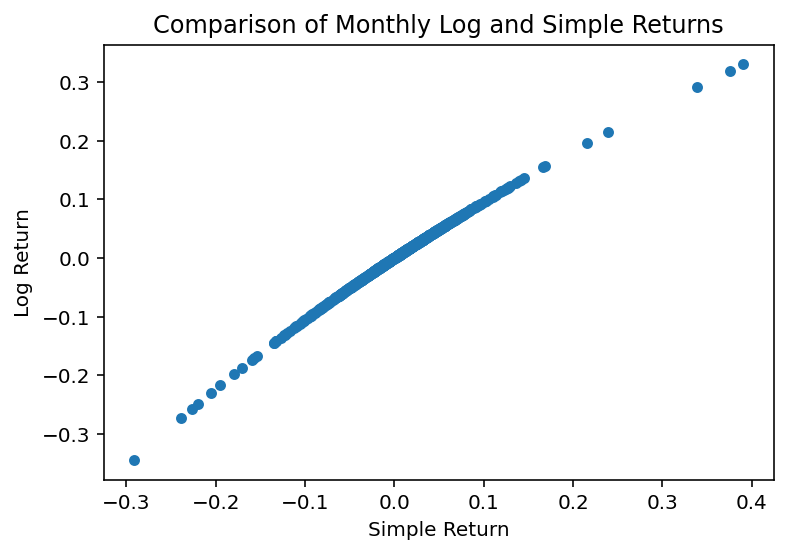

<Figure size 720x432 with 0 Axes>

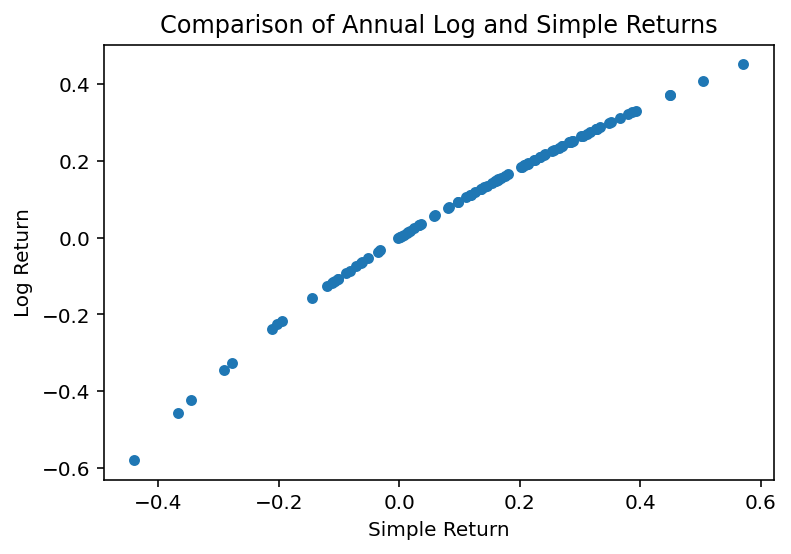

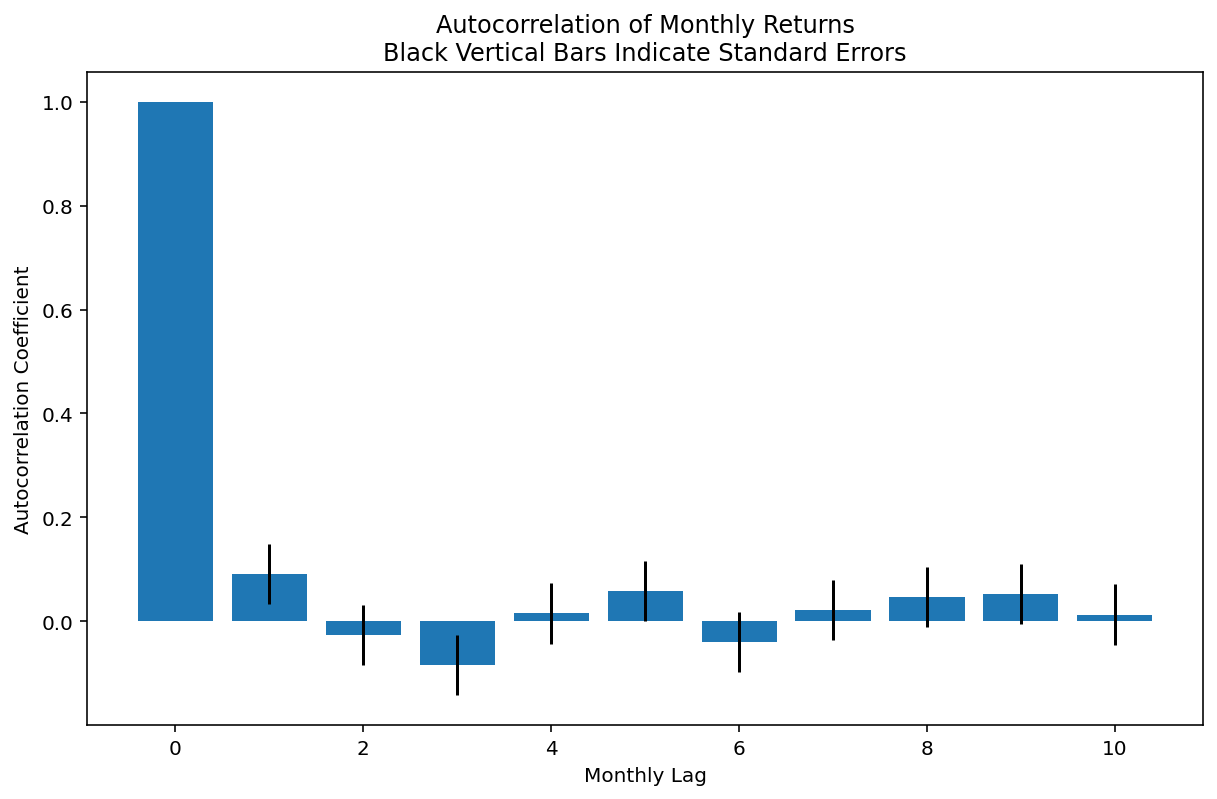

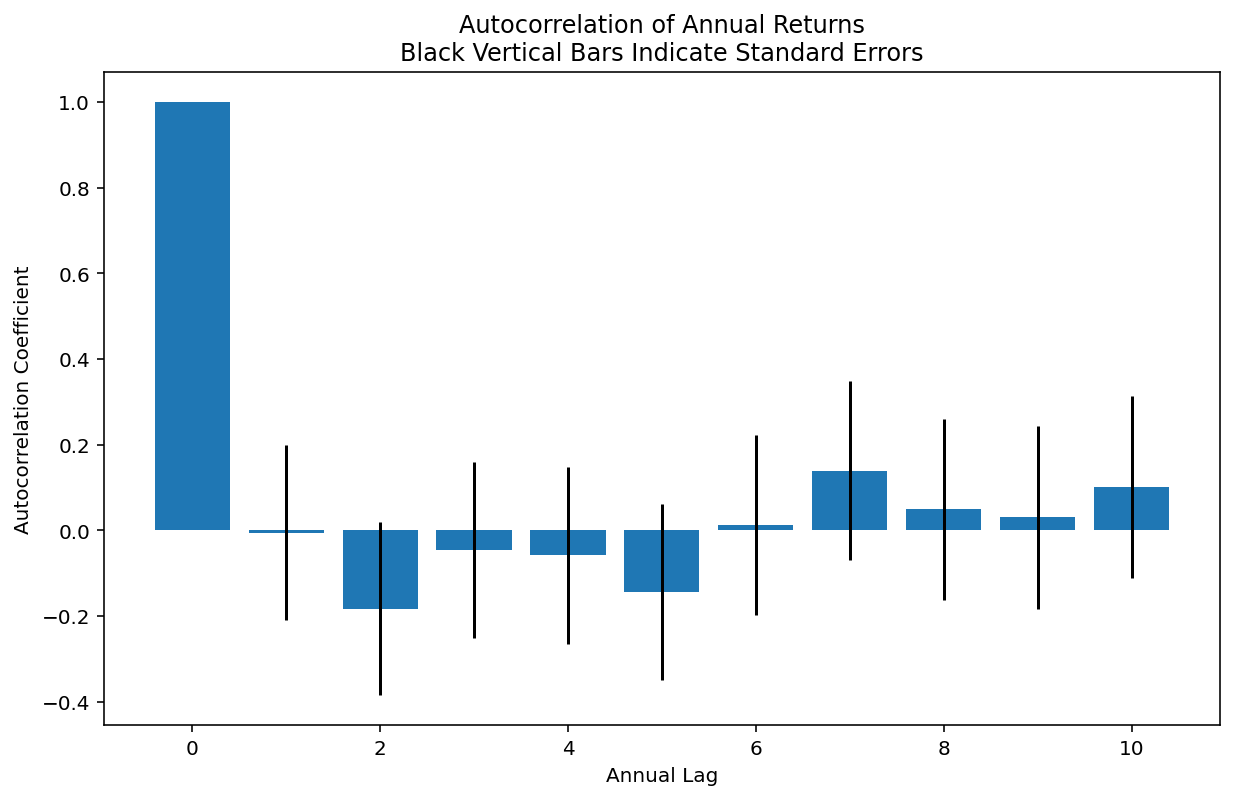

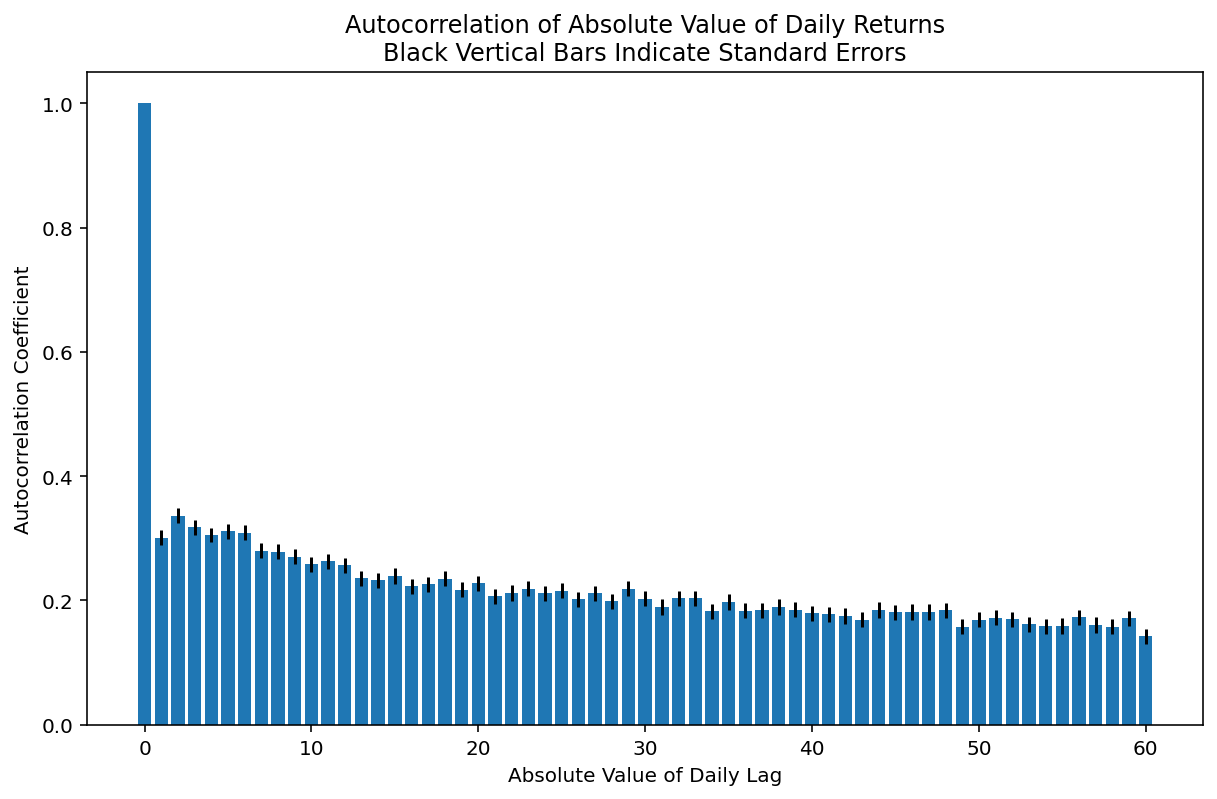

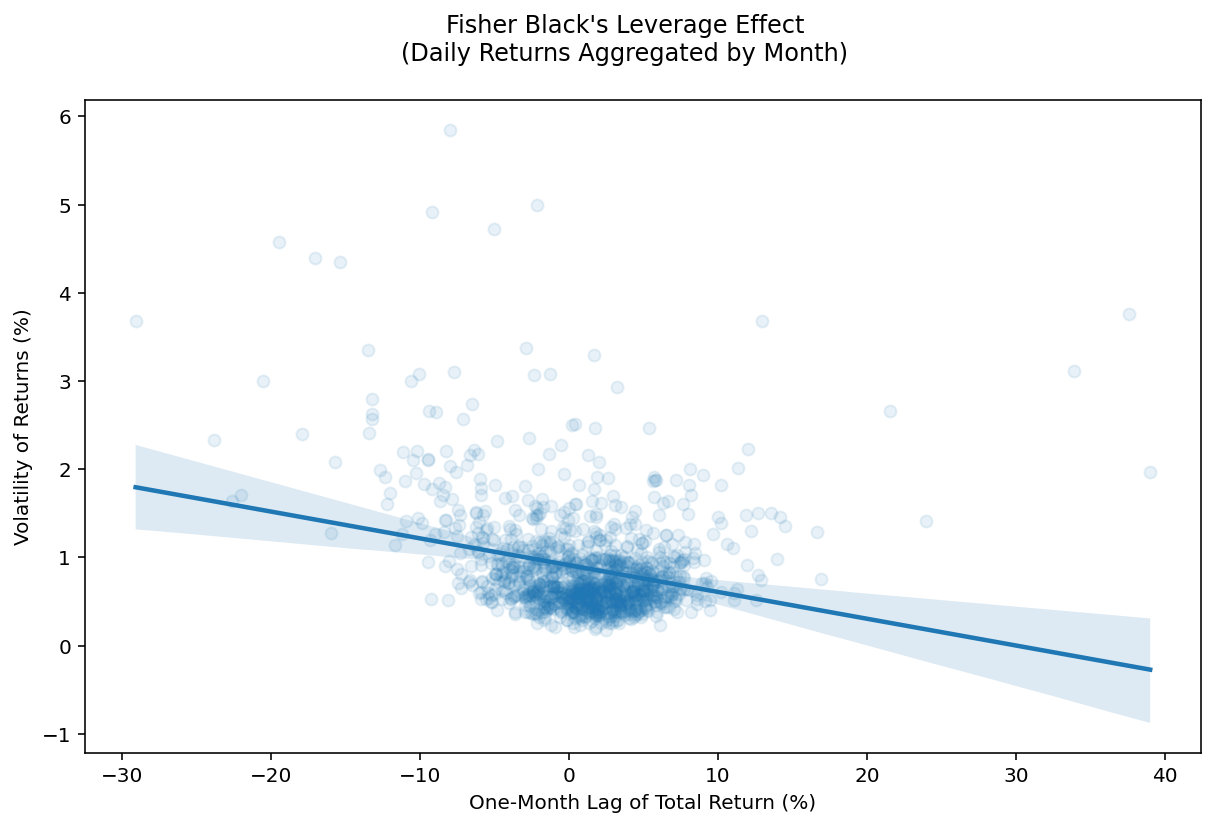

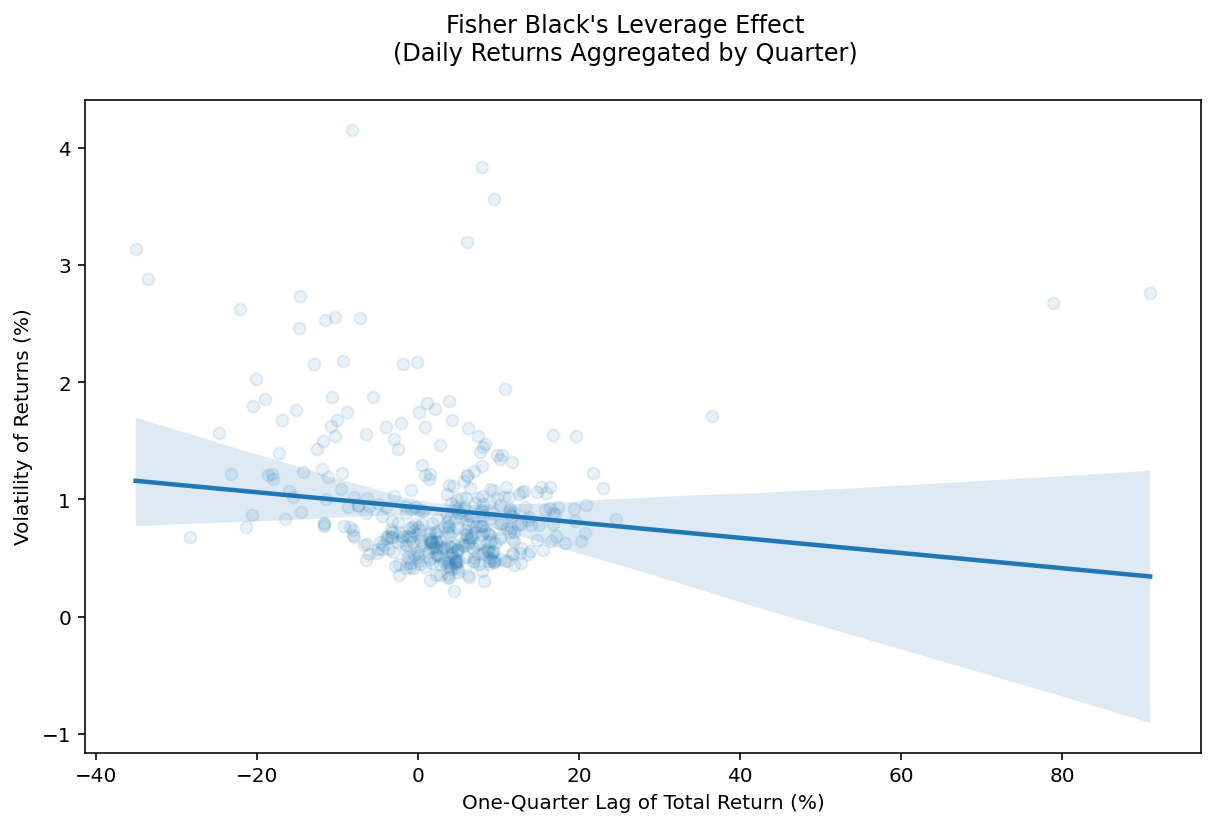

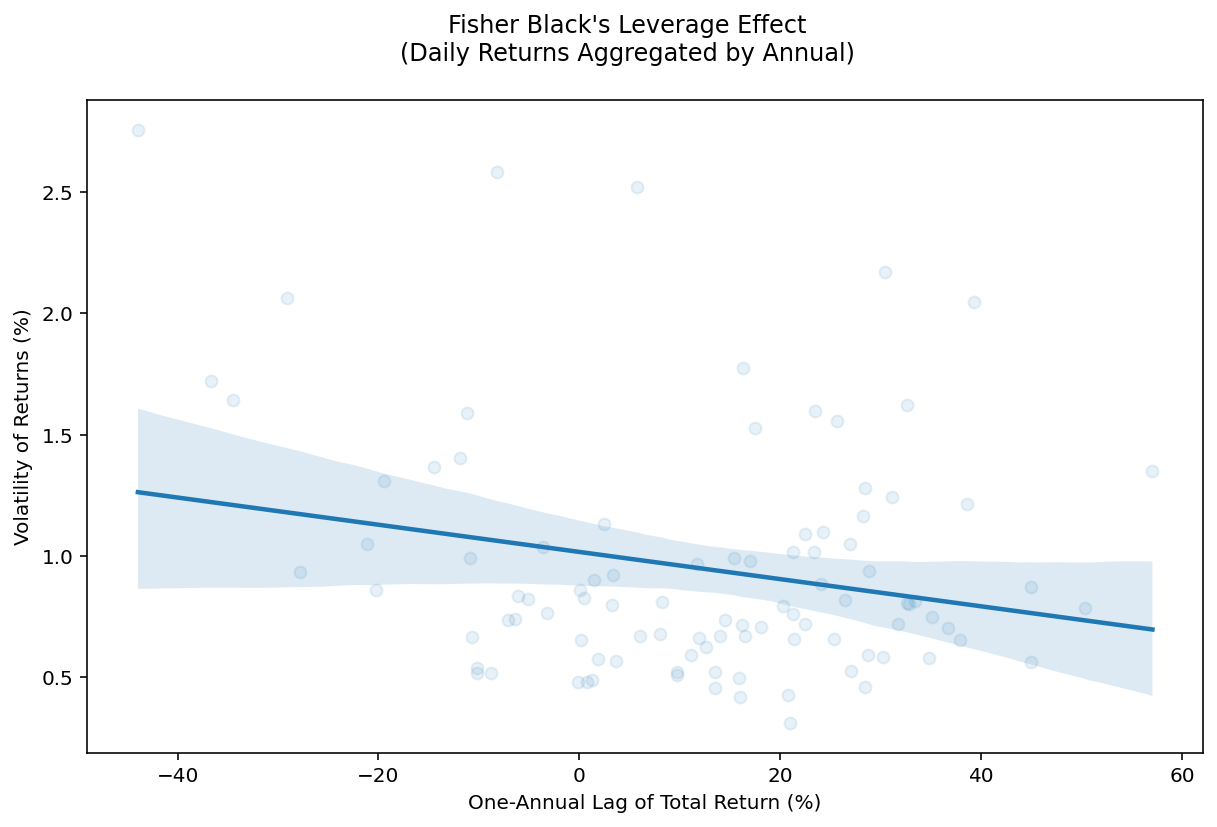

<Figure size 720x432 with 0 Axes>

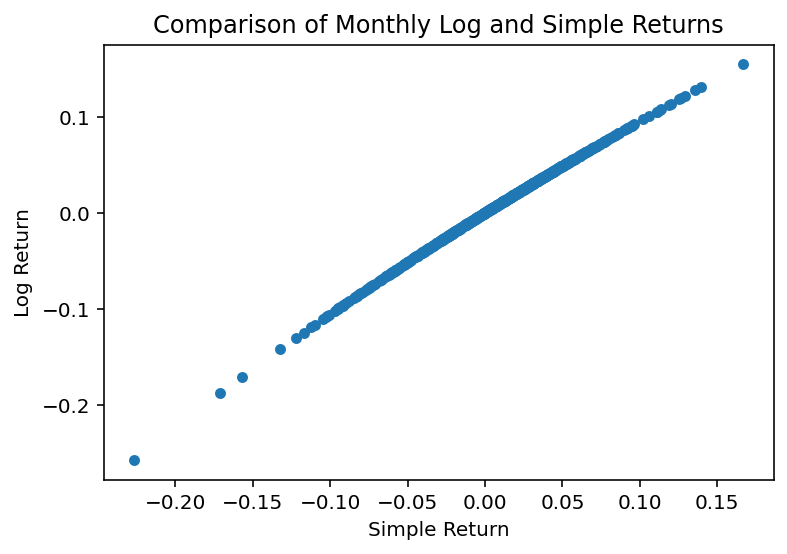

<Figure size 720x432 with 0 Axes>

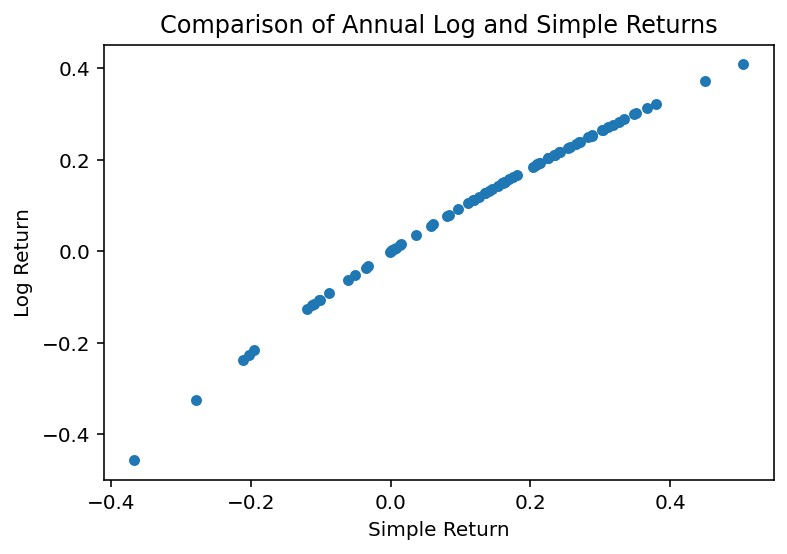

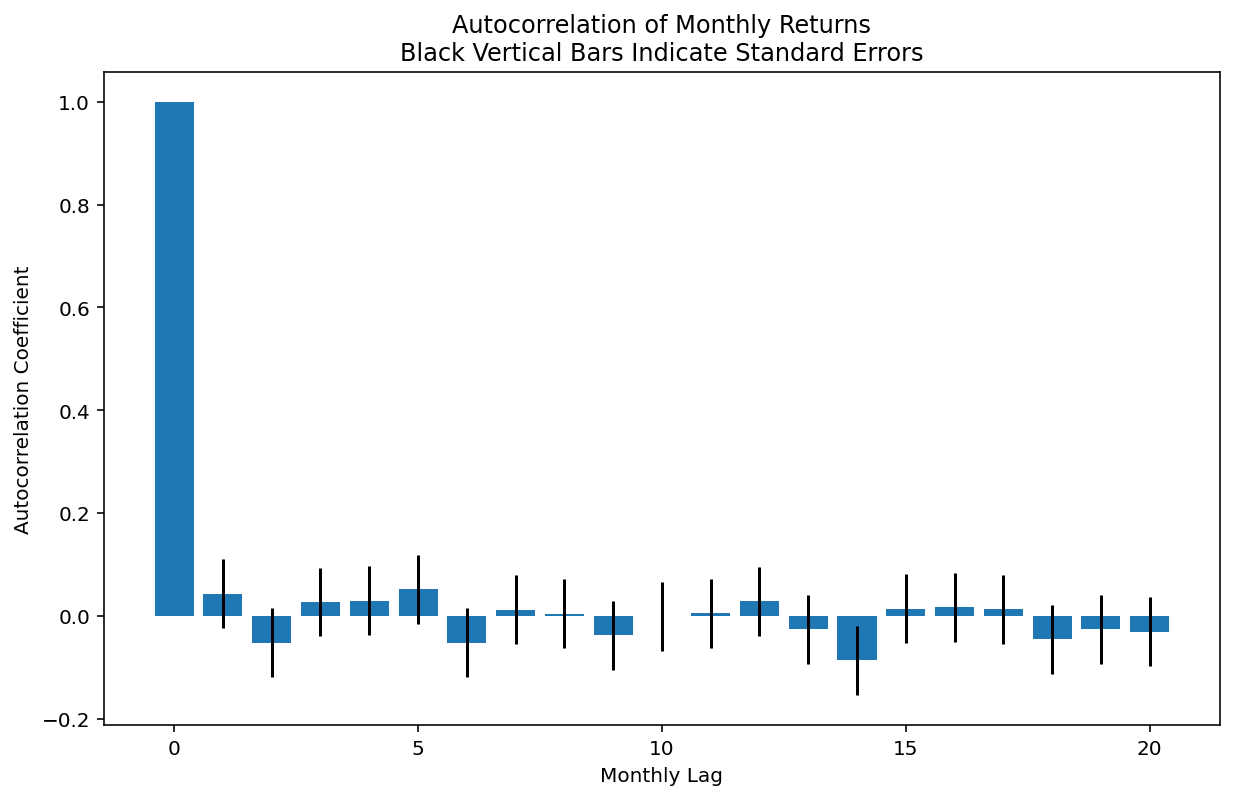

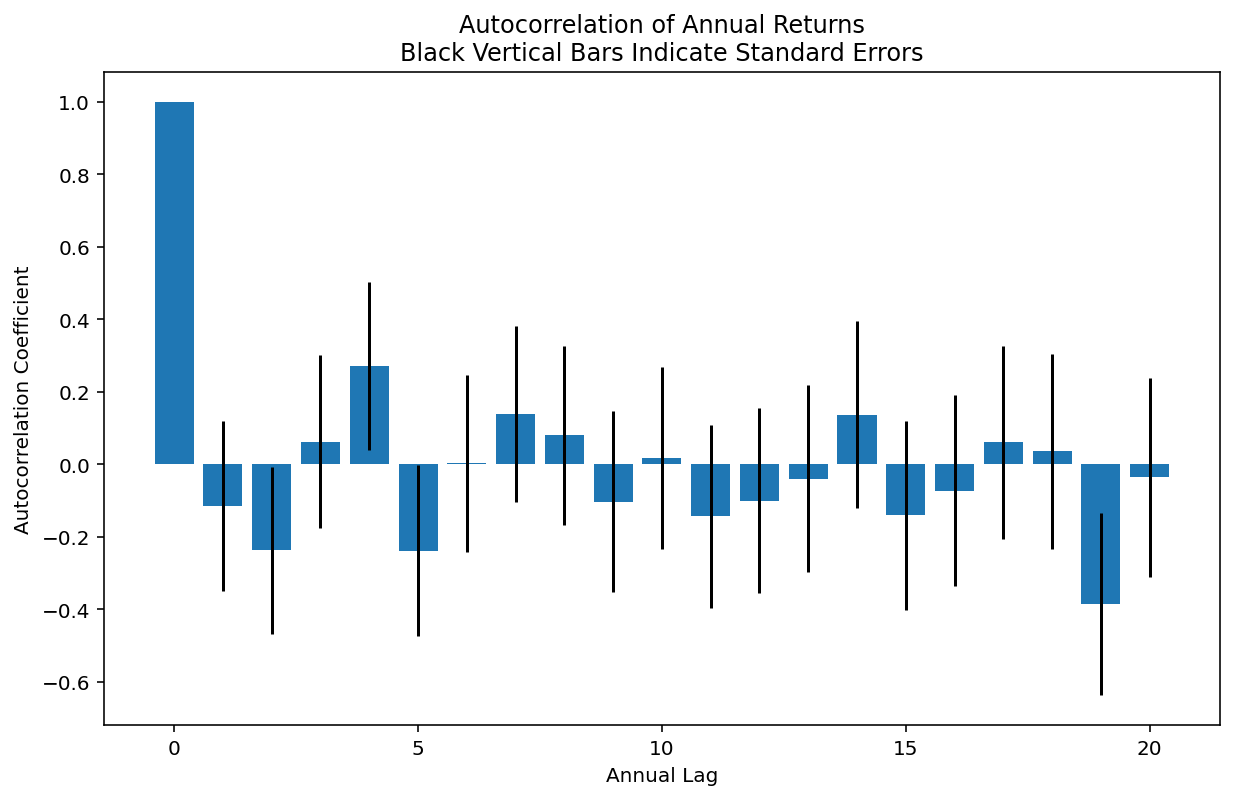

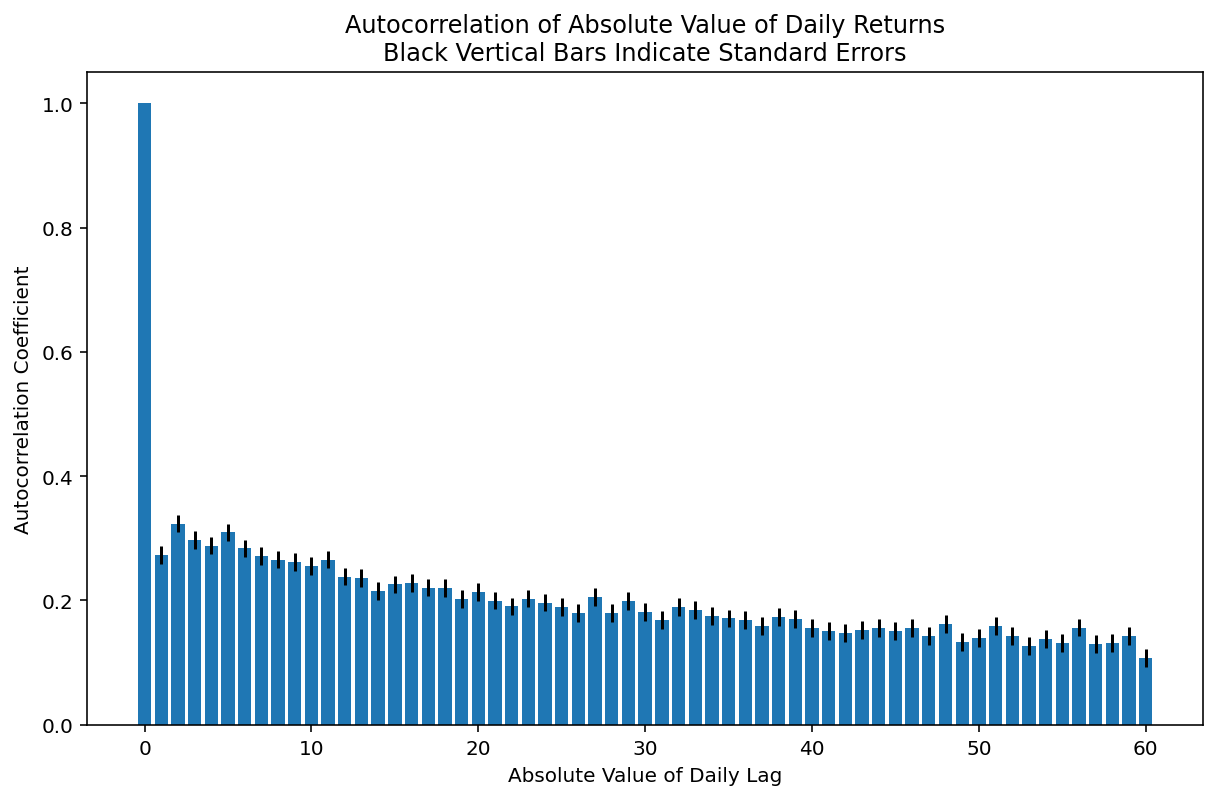

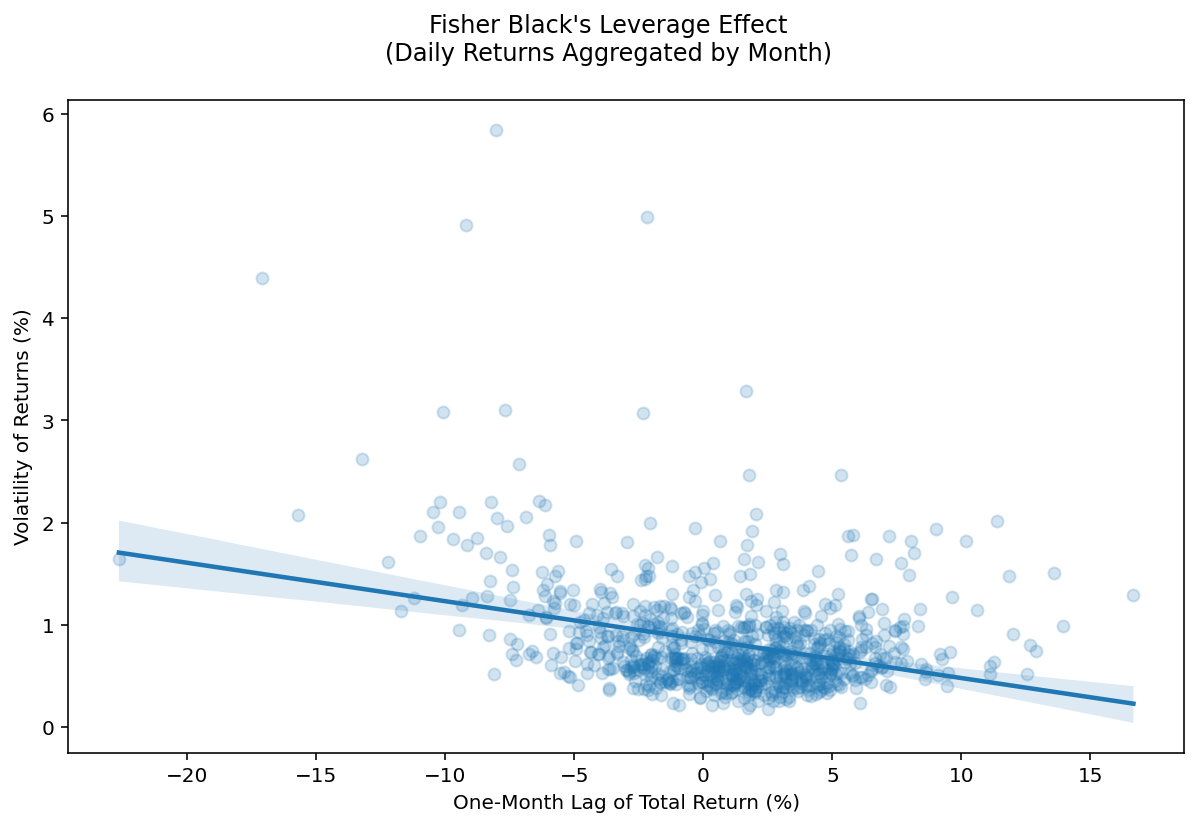

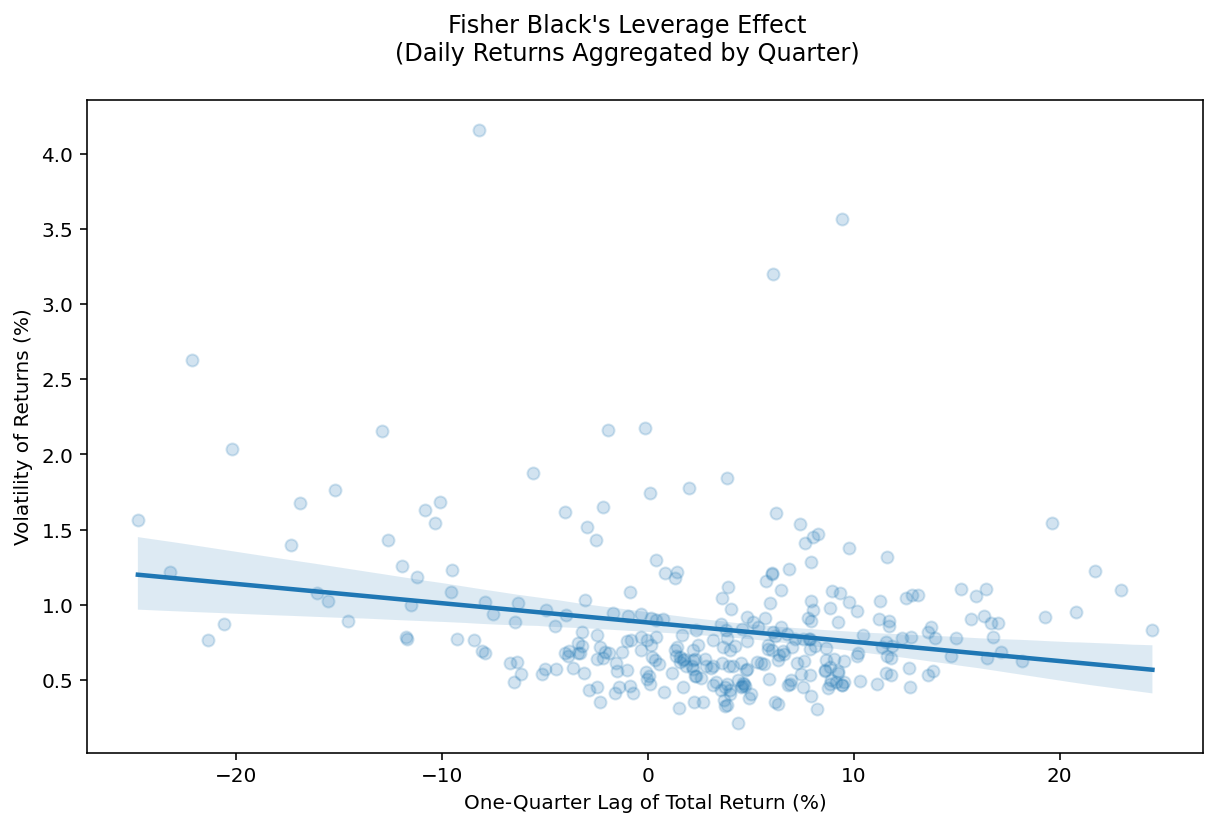

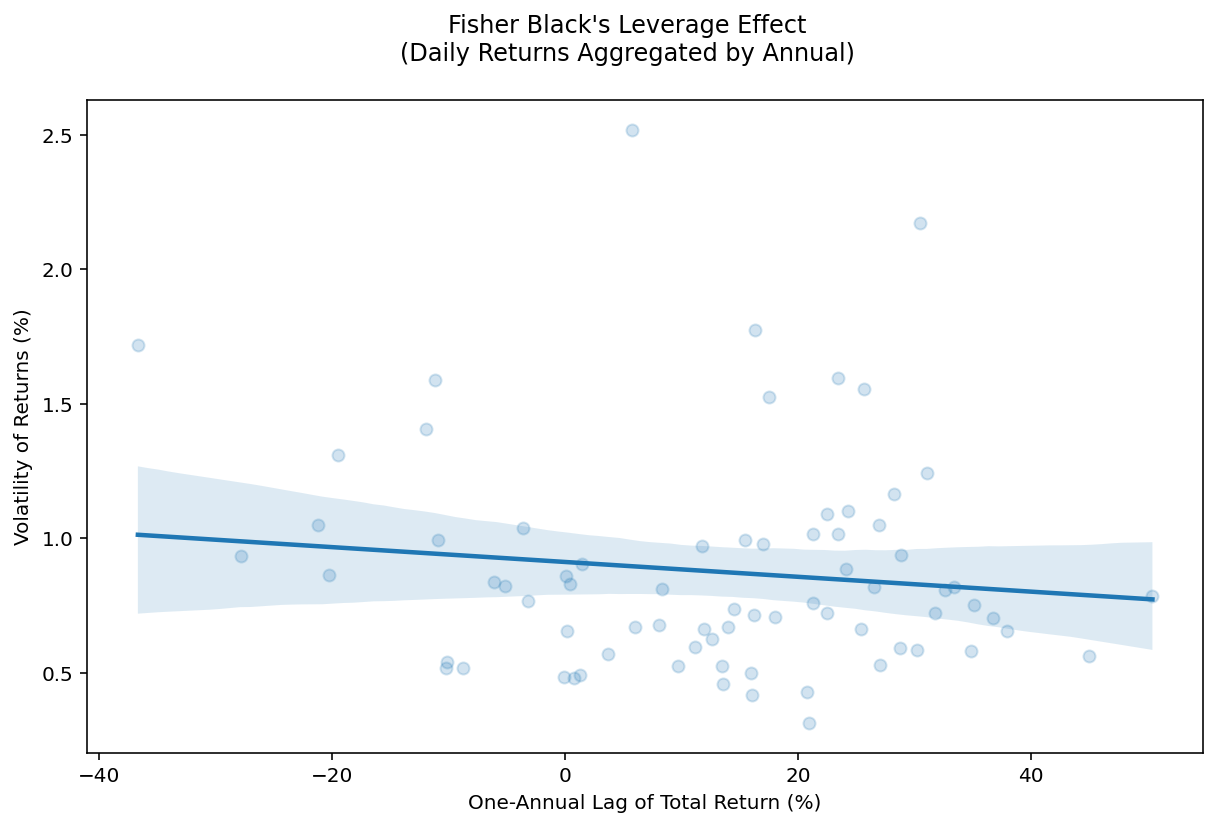

Daily Return Statistics:
               R       logR
count 25860.0000 25860.0000
mean      0.0004     0.0004
std       0.0108     0.0108
min      -0.1741    -0.1913
25%      -0.0039    -0.0039
50%       0.0008     0.0007
75%       0.0051     0.0051
max       0.1576     0.1464

Monthly Return Statistics:
              R      logR
count 1180.0000 1180.0000
mean     0.0095    0.0081
std      0.0533    0.0532
min     -0.2911   -0.3440
25%     -0.0178   -0.0180
50%      0.0131    0.0130
75%      0.0396    0.0389
max      0.3903    0.3295

Period Information:
{'start_date': Timestamp('1926-07-01 00:00:00'), 'end_date': Timestamp('2024-10-31 00:00:00'), 'total_days': 25860, 'total_months': 1180, 'total_years': 99}


In [4]:
# Example usage:

# Basic analysis with all plots
results = analyze_market_returns()

# Analysis without plots
results_no_plots = analyze_market_returns(show_plots=False)

# Analysis with custom parameters
custom_results = analyze_market_returns(
    start_year='1950',
    autocorr_lags=20,
    leverage_alpha=0.2
)

# Access various results
print("Daily Return Statistics:")
print(results['summary_stats']['daily'])

print("\nMonthly Return Statistics:")
print(results['summary_stats']['monthly'])

print("\nPeriod Information:")
print(results['period_info'])